In [196]:
cd ~/data/modl_data/pipeline/contrast/prediction/573/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/573


In [197]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline

In [198]:
estimator = load('estimator.pkl')

In [199]:
coef = estimator.named_steps['logistic_regression'].coef_
intercept = estimator.named_steps['logistic_regression'].intercept_
pipeline = Pipeline(estimator.steps[:-1])

In [200]:
(coef == 0).sum() / coef.size

0.31120600414078675

In [201]:
intercept

array([ -4.2958203 , -11.84310346,  -9.5168294 ,  -4.44499192,
        -5.67971119,  -8.601671  , -10.09207495,  -4.79989428,
       -21.1660747 , -10.03905282, -20.32466296, -22.98112792,
        -5.87892335, -18.5990682 ,  -4.71736023, -19.83171226,
        -7.51995949,  -4.90101415, -16.70563396, -17.40451698,
        -9.70312242, -30.60215023, -20.71566312])

In [202]:
maps = pipeline.inverse_transform(coef)

In [203]:
from nilearn.input_data import MultiNiftiMasker

In [204]:
from modl.datasets.hcp import fetch_hcp
mask = fetch_hcp(n_subjects=1).mask

In [205]:
masker = MultiNiftiMasker(mask_img=mask).fit()

In [206]:
imgs = masker.inverse_transform(maps)

In [207]:
label_encoder = load('label_encoder.pkl')

In [208]:
import pandas as pd

In [209]:
labels = pd.read_csv('prediction.csv').loc[:23, 'contrast']
indices = label_encoder.transform(labels)

In [210]:
prediction = pd.read_csv('prediction.csv')
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)

In [211]:
prediction['match'].groupby(level=['fold', 'task', 'contrast']).apply(np.mean)

fold   task        contrast 
test   EMOTION     FACES        0.962025
                   SHAPES       0.949367
       GAMBLING    PUNISH       0.797468
                   REWARD       0.759494
       LANGUAGE    MATH         0.924051
                   STORY        0.924051
       MOTOR       CUE          1.000000
                   LF           0.961538
                   LH           0.987179
                   RF           0.961538
                   RH           0.987179
       RELATIONAL  MATCH        0.858974
                   REL          0.756410
       SOCIAL      RANDOM       0.961538
                   TOM          0.961538
       WM          0BK_BODY     0.696203
                   0BK_FACE     0.822785
                   0BK_PLACE    0.898734
                   0BK_TOOL     0.772152
                   2BK_BODY     0.772152
                   2BK_FACE     0.873418
                   2BK_PLACE    0.835443
                   2BK_TOOL     0.898734
train  EMOTION     FACES    

In [212]:
from sklearn.metrics import confusion_matrix

In [213]:
contrasts = prediction['true_label'].iloc[:23]
conf = confusion_matrix(prediction.loc['test', 'true_label'].values,
                        prediction.loc['test', 'predicted_label'], labels=contrasts)

In [214]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(conf_arr,
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=45)

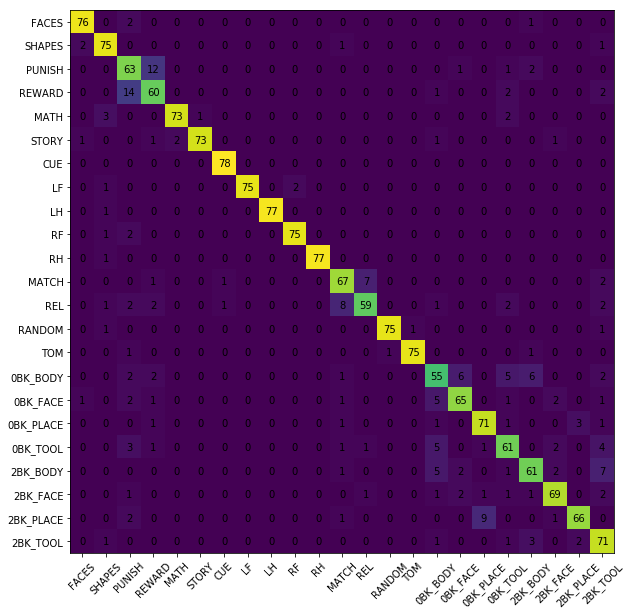

In [215]:
plot_confusion_matrix(conf, contrasts)

In [217]:
prediction['match'].groupby(level=['fold', 'task', 'contrast']).apply(np.mean)

fold   task        contrast 
test   EMOTION     FACES        0.962025
                   SHAPES       0.949367
       GAMBLING    PUNISH       0.797468
                   REWARD       0.759494
       LANGUAGE    MATH         0.924051
                   STORY        0.924051
       MOTOR       CUE          1.000000
                   LF           0.961538
                   LH           0.987179
                   RF           0.961538
                   RH           0.987179
       RELATIONAL  MATCH        0.858974
                   REL          0.756410
       SOCIAL      RANDOM       0.961538
                   TOM          0.961538
       WM          0BK_BODY     0.696203
                   0BK_FACE     0.822785
                   0BK_PLACE    0.898734
                   0BK_TOOL     0.772152
                   2BK_BODY     0.772152
                   2BK_FACE     0.873418
                   2BK_PLACE    0.835443
                   2BK_TOOL     0.898734
train  EMOTION     FACES    

In [218]:
title = pd.read_csv('prediction.csv').loc[:23, ['task', 'contrast']]

In [219]:
titles = ["%s: %s" % (value['task'], value['contrast']) for _, value in title.iterrows()]

/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


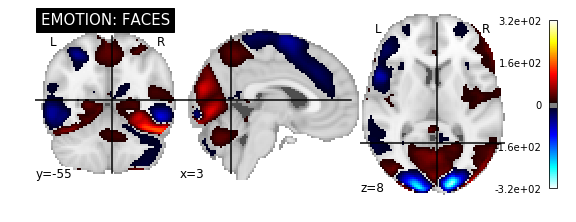

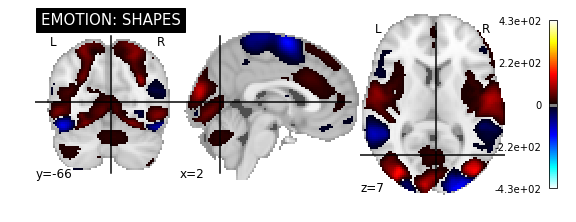

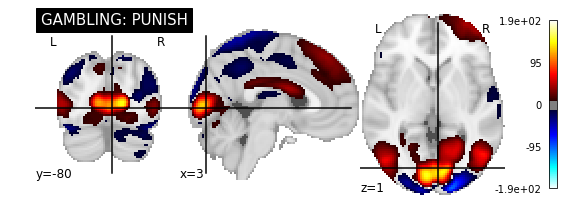

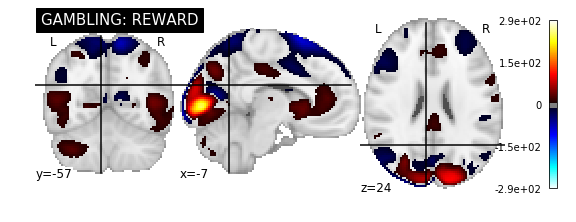

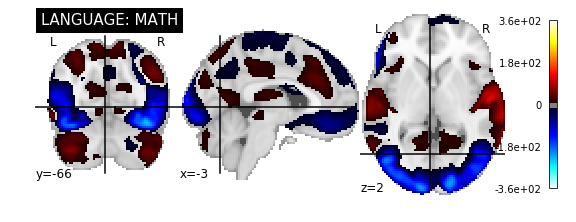

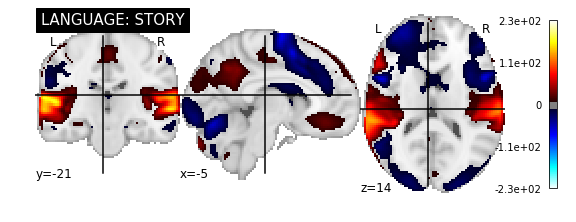

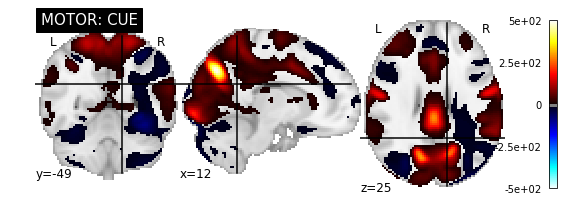

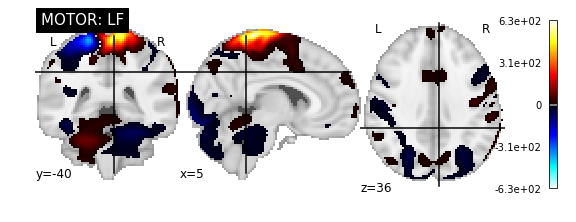

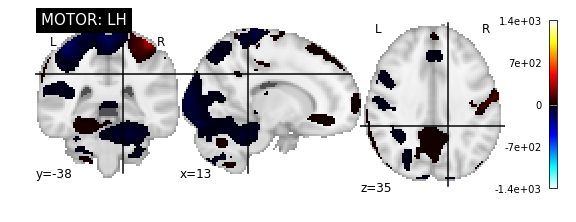

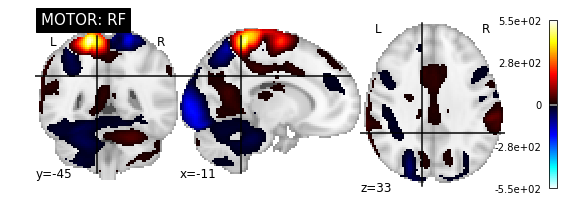

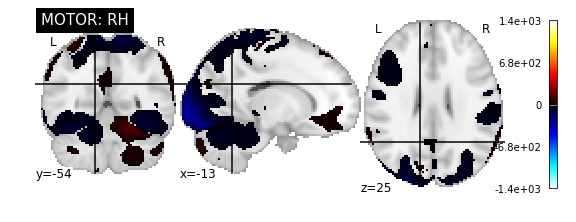

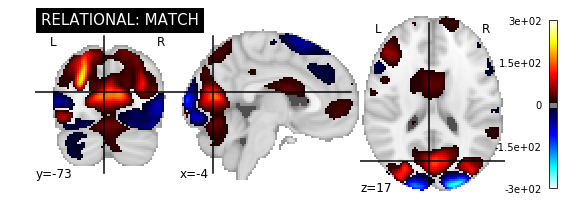

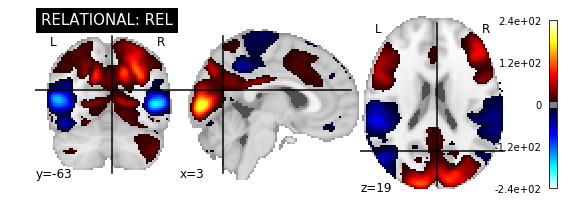

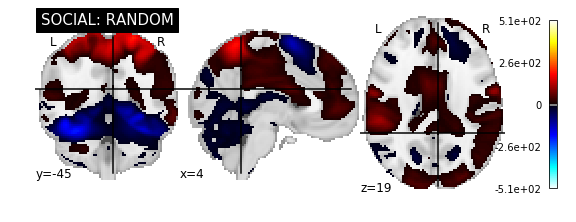

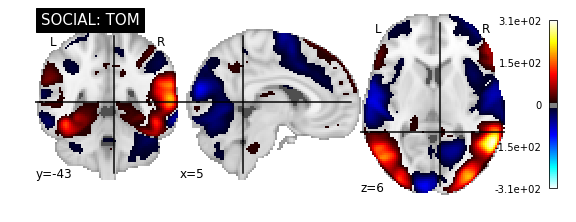

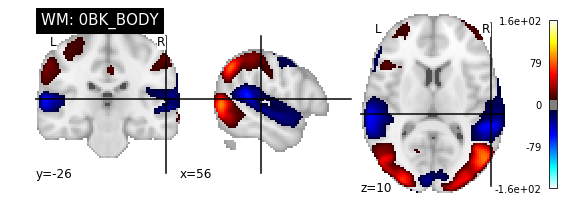

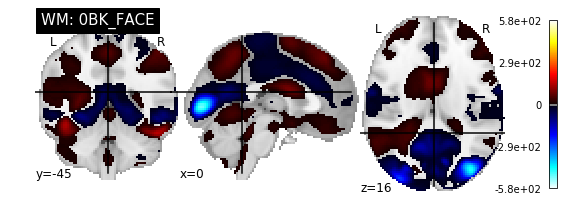

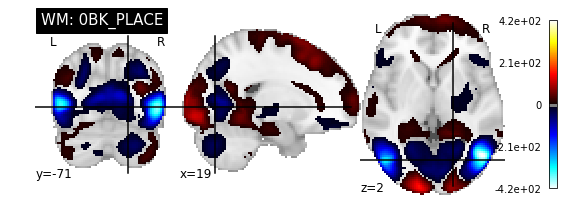

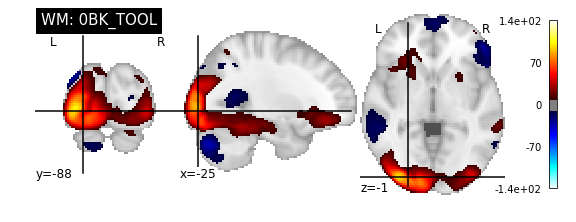

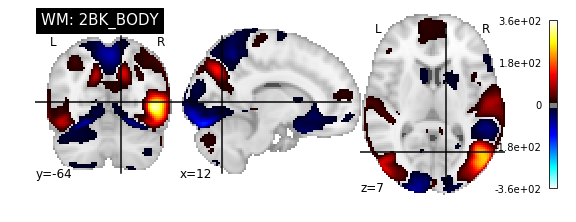

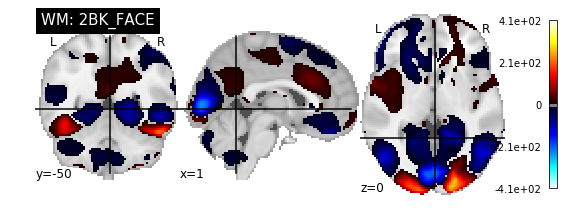

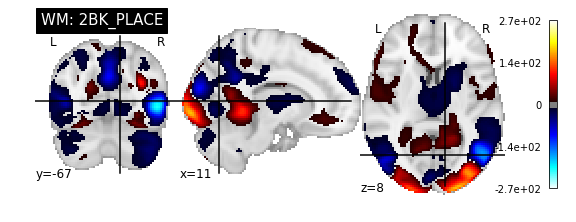

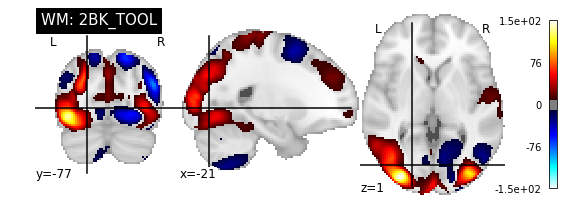

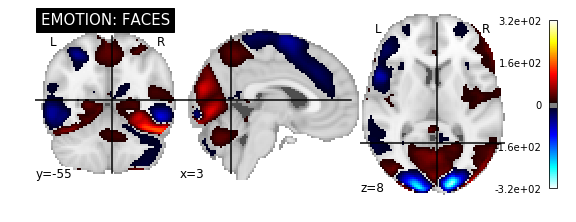

In [233]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=10)

In [227]:
(np.abs(coef[:,:16]).sum())

223.63472335777993

In [228]:
(np.abs(coef[:,16:80])).sum()

931.91780012609593

In [229]:
np.abs(coef[:,80:80 + 256]).sum()

3731.9873692194706

In [230]:
np.sum(coef[:, :16] == 0) / coef[:, :16].size

0.07880434782608696

In [231]:
np.sum(coef[:, 16:80] == 0) / coef[:, 16:80].size

0.19089673913043478

In [232]:
np.sum(coef[:, 80:256] == 0) / coef[:, 80:256].size

0.35103754940711462